In [ ]:
!pip install fiftyone==1.5.2 > /dev/null

## Understanding Denoising Diffusion Probabilistic Models (MNIST digit generation)

![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/images/generated_mnist_digits_FO.png)



* U-Net: For the noise prediction network in the Denoising Diffusion Probabilisit Model (DDPM)
* Diffusion Process: Defines how noise is added (forward) and removed (reverse).
* MNIST Classifier: A standard convolutional neural network for classifying digits. It doesn't share gradients or information with the U-net, we use it just to evaluate the quality of predictions.
* Training Loops: One for the DDPM, one for the classifier.
* Sampling & Evaluation: Generating digits from the DDPM and classifying them.



# Benefits of U-Net's Downsampling-Upsampling Architecture in Diffusion Models

## Multi-scale Feature Processing
- U-Net captures hierarchical image features through progressive downsampling
- Lower resolutions encode global context and structure
- Higher resolutions preserve fine details and textures
- This multi-scale approach matches diffusion's noise characteristics at different timesteps

## Efficient Long-range Dependencies
- Downsampling increases effective receptive field without computational explosion
- Later timesteps (more noise) require global context to reconstruct structure
- Earlier timesteps (less noise) need local precision for detail refinement
- U-Net addresses both through its pyramidal architecture

## Skip Connections Preserve Information
- Skip connections between corresponding encoding/decoding layers maintain critical information
- These connections combat vanishing gradients in deep networks
- They create residual pathways that help preserve spatial details lost during downsampling
- Particularly valuable in diffusion models where preserving underlying image structure is essential

## Parameter Efficiency
- Downsampling reduces spatial dimensions, allowing deeper networks with manageable parameters
- Deeper networks capture more complex noise patterns across diffusion timesteps
- Upsampling gradually reconstructs spatial resolution while maintaining semantic understanding
- This efficiency enables handling the complex mapping from noisy to clean images

## Resolution-dependent Processing
- Different stages in diffusion process benefit from different resolution processing:
  - Early denoising (high noise): Benefits from low-resolution processing focused on structural elements
  - Late denoising (low noise): Requires high-resolution processing for detail refinement
- U-Net's architecture naturally aligns with this progression

## Consistent with Diffusion Physics
- Noise diffusion follows a coarse-to-fine pattern in physical systems
- U-Net's architecture mimics this natural process:
  - Downsampling path: Identifies global structures in highly noisy images
  - Upsampling path: Progressively refines details as noise levels decrease
- This alignment improves model convergence and generation quality

## Attention Integration
- Modern diffusion U-Nets incorporate self-attention at lower resolutions
- This combines convolutional inductive bias with transformer-like global reasoning
- Particularly valuable for coherent structure generation in highly degraded images

The U-Net architecture  balances global context and local detail processing, making it suited for the progressive denoising task of diffusion models across their full timestep spectrum.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import shutil
import fiftyone as fo

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

IMG_SIZE = 28 # MNIST image size
BATCH_SIZE_DDPM = 128
BATCH_SIZE_CLASSIFIER = 64
# Learning rates
LR_DDPM = 1e-3
LR_CLASSIFIER = 1e-3
EPOCHS_DDPM = 50 # Increase for better results (e.g., 100-200)
EPOCHS_CLASSIFIER = 10 # Usually converges faster
T = 300 # Number of diffusion timesteps (can be 200-1000)
SAVE_INTERVAL_DDPM = 10 # Save generated images every N epochs
OUTPUT_DIR = "ddpm_mnist_output"
CLASSIFIER_MODEL_PATH = os.path.join(OUTPUT_DIR, "mnist_classifier.pth")
DDPM_MODEL_PATH = os.path.join(OUTPUT_DIR, "ddpm_unet.pth")

os.makedirs(OUTPUT_DIR, exist_ok=True)



Using device: cuda


# Why We Use Positional Embeddings for Timesteps

Sinusoidal positional embeddings for timesteps `t` in Denoising Diffusion Probabilistic Models serve several critical functions:

## Purpose
- The U-Net predicts noise `ε` added to image `x_0` to produce `x_t`
- Noise characteristics depend on timestep `t` - early timesteps have minimal noise while late timesteps contain mostly noise
- The U-Net requires timestep information to predict the appropriate noise to remove

## Problems with Raw Integer Timesteps
- **Scale Issues:** Raw integers (0-1000) have disparate magnitudes that complicate neural network learning
- **Interpretation Gaps:** Networks may treat each integer as distinct, missing the relationship between adjacent timesteps
- **Limited Range:** Raw integers provide no framework for understanding timesteps outside training range
- **Insufficient Information:** A single scalar value lacks expressiveness for timestep representation

## Benefits of Sinusoidal Positional Embeddings
- **Unique Vectors:** Each timestep receives a distinct vector representation
- **Fixed Calculation:** Embeddings derive from sine/cosine functions rather than learning, providing consistency
- **Continuity:** Smooth functions create proximity between adjacent timesteps in embedding space, enabling interpolation
- **Structured Relationships:** For offset `k`, embedding of `t+k` can be expressed as linear function of embedding `t`
- **Frequency Spectrum:** Multiple frequencies capture both coarse and fine-grained timestep relationships:
  ```
  PE(t, 2i)   = sin(t / 10000^(2i / d_model))
  PE(t, 2i+1) = cos(t / 10000^(2i / d_model))
  ```
  - Low frequencies (large wavelengths) capture broad noise patterns
  - High frequencies (small wavelengths) differentiate between adjacent timesteps
- **Value Constraints:** Sine/cosine outputs bound between -1 and 1, stabilizing network training
- **Dimensional Richness:** Vector representation (256-512 dimensions) provides depth beyond scalar values

## Implementation in U-Net Architecture
- Integer timestep `t` converts to sinusoidal positional embedding vector
- This vector passes through a multi-layer perceptron for transformation
- The resulting embedding integrates with U-Net feature maps via addition or concatenation, conditioning the network on the noise level

In [ ]:
# --- Helper: Sinusoidal Positional Embeddings for Timesteps ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [ ]:
# --- U-Net Architecture ---
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1) # Downsample
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Downsample or Upsample
        return self.transform(h)

class UNet(nn.Module):
    def __init__(self, img_channels=1, time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.initial_conv = nn.Conv2d(img_channels, 64, 3, padding=1)

        # Downsampling
        self.down1 = Block(64, 128, time_emb_dim) # 28x28 -> 14x14
        self.down2 = Block(128, 256, time_emb_dim) # 14x14 -> 7x7

        # Bottleneck (no down/upsample)
        self.sa1 = Block(256, 256, time_emb_dim) # 7x7 -> 3x3 (due to kernel 4, stride 2, padding 1 in transform)
                                                    # Let's adjust transform in Block for bottleneck
                                                    # Or, use a simpler conv block for bottleneck
        self.bot1 = nn.Conv2d(256, 512, 3, padding=1)
        self.bot2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bot3 = nn.Conv2d(512, 256, 3, padding=1)


        # Upsampling
        self.up1 = Block(256 + 256, 128, time_emb_dim, up=True) # 3x3 -> 7x7 (adjust for skip)
        self.up2 = Block(128 + 128, 64, time_emb_dim, up=True) # 7x7 -> 14x14

        # Output
        self.out_conv = nn.Conv2d(64 + 64, img_channels, kernel_size=1) # Match original image size (28x28)
                                                                     # This needs adjustment if upsampling reaches full size.
                                                                     # Let's make sure upsampling goes to 28x28
        # For U-Net, the upsampling should bring it back to the original size BEFORE the final output conv
        # Let's redefine the upsampling path slightly to ensure correct sizes
        # For MNIST 28x28:
        # 28 -> 14 -> 7 (down)
        # 7 (bottleneck)
        # 7 -> 14 -> 28 (up)

        # Re-defining U-Net for clarity on dimensions
        # Input: (B, 1, 28, 28)
        self.down1 = Block(64, 128, time_emb_dim)      # Output: (B, 128, 14, 14)
        self.down2 = Block(128, 256, time_emb_dim)     # Output: (B, 256, 7, 7)

        # Bottleneck (no spatial change here, just convs)
        self.sa_in_ch = 256
        self.sa_out_ch = 256
        self.bot_conv1 = nn.Conv2d(self.sa_in_ch, self.sa_out_ch, 3, padding=1)
        self.bot_relu = nn.ReLU()
        self.bot_conv2 = nn.Conv2d(self.sa_out_ch, self.sa_out_ch, 3, padding=1)
        # No transform in bottleneck, so `t` needs to be processed differently or not used in simple bottleneck
        # Let's add time embedding to bottleneck too for consistency
        self.bot_time_mlp = nn.Linear(time_emb_dim, self.sa_out_ch)

        self.up0 = Block(256, 128, time_emb_dim, up=True)      # Input skip from down2: (B, 128, 14, 14)
        self.up1 = Block(128, 64, time_emb_dim, up=True)       # Input skip from down1: (B, 64, 28, 28)

        # Output layer
        self.output = nn.Conv2d(64, img_channels, kernel_size=1) # Should be (B, 1, 28, 28)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)

        x = self.initial_conv(x) # (B, 64, 28, 28)

        # Downsampling path
        x1 = self.down1(x, t)    # (B, 128, 14, 14)
        x2 = self.down2(x1, t)   # (B, 256, 7, 7)

        # Bottleneck
        b = self.bot_conv1(x2)
        time_emb_bot = self.bot_relu(self.bot_time_mlp(t))
        time_emb_bot = time_emb_bot[(...,) + (None,) * 2]
        b = b + time_emb_bot
        b = self.bot_conv2(self.bot_relu(b)) # (B, 256, 7, 7)

        # Upsampling path
        # To handle skip connections, the Block's 'up' conv1 needs to take 2*in_ch
        # The input to up0 will be b and x2. Output of down2 is x2 (256 channels)
        # The input to up1 will be output_of_up0 and x1. Output of down1 is x1 (128 channels)
        # The input to self.output will be output_of_up1 and x. Initial_conv output (64 channels)

        # For skip connection, the input to Block(up=True) is already prepared
        # by concatenating. Let's adjust the Block up=True part.
        # Block(in_ch, out_ch) means in_ch from previous layer, out_ch is the target for this block's output.
        # So for up=True, conv1 should take (in_ch_skip + in_ch_previous_upsample)
        # It's simpler if Block handles concatenation internally if up=True.
        # Let's make Block take `in_ch_skip` as an additional argument for `up=True`
        # Or, just define the concat explicitly here.

        u0 = self.up0(torch.cat((b, x2), 1), t)      # Input: (B, 256+256, 7, 7) -> (B, 128, 14, 14)
        u1 = self.up1(torch.cat((u0, x1), 1), t)     # Input: (B, 128+128, 14, 14) -> (B, 64, 28, 28)

        # Final output
        # Skip connection with initial conv output
        # return self.output(torch.cat((u1, x), 1)) # This concat logic is handled by last Block implicitly
        return self.output(u1) # The U-Net output structure usually has final conv on last upsample layer directly


In [ ]:
# --- Diffusion Process ---
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ Returns a specific index t of a list of values vals for a batch of shape x_shape """
    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

class Diffusion:
    def __init__(self, timesteps=T, img_size=IMG_SIZE, device=DEVICE):
        self.timesteps = timesteps
        self.img_size = img_size
        self.device = device

        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        """ Forward process: q(x_t | x_0) """
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = get_index_from_list(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    @torch.no_grad()
    def p_sample(self, model, x, t, t_index):
        """ Reverse process: p(x_{t-1} | x_t) """
        betas_t = get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # Equation 11 in DDPM paper
        # Use our model (noise predictor) to predict the mean
        model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = get_index_from_list(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def sample(self, model, image_size, batch_size=16, channels=1):
        """ Sample batch_size images """
        shape = (batch_size, channels, image_size, image_size)
        img = torch.randn(shape, device=self.device)
        imgs = []

        for i in tqdm(reversed(range(0, self.timesteps)), desc='Sampling loop time step', total=self.timesteps):
            t = torch.full((batch_size,), i, device=self.device, dtype=torch.long)
            img = self.p_sample(model, img, t, i)
            # Optionally, clip to [-1, 1] at each step if desired, though often done at the end.
            # img = torch.clamp(img, -1.0, 1.0)
            if i % (self.timesteps // 10) == 0 or i < 10 : # Store some intermediate steps
                 imgs.append(img.cpu())
        imgs.append(img.cpu()) # final image
        return imgs # Returns a list of tensors, last one is the final result

    def p_losses(self, denoise_model, x_start, t, noise=None, loss_type="l1"):
        if noise is None:
            noise = torch.randn_like(x_start)

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        predicted_noise = denoise_model(x_noisy, t)

        if loss_type == 'l1':
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == 'l2':
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "huber":
            loss = F.smooth_l1_loss(noise, predicted_noise)
        else:
            raise NotImplementedError()
        return loss



In [ ]:
# --- MNIST Classifier ---
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 14x14 -> 7x7
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 10 classes for MNIST

    def forward(self, x):
        # DDPM output is [-1, 1]. Classifier usually trained on [0,1] or normalized differently.
        # Let's assume classifier expects [0,1] then normalizes internally, or we normalize before passing.
        # For simplicity, let's make classifier expect [-1, 1] directly for generated images.
        # If training classifier on original MNIST, it will see [0,1] normalized to [-1,1] by transform.
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# --- Data Loading ---
import torch.nn.functional as F
from tqdm import tqdm

transform_ddpm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                # Scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Scales to [-1, 1]
])

transform_classifier = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard MNIST normalization
])

# For DDPM training
train_dataset_ddpm = datasets.MNIST('.', train=True, download=True, transform=transform_ddpm)
train_loader_ddpm = DataLoader(train_dataset_ddpm, batch_size=BATCH_SIZE_DDPM, shuffle=True, drop_last=True)

# For Classifier training and evaluation
train_dataset_classifier = datasets.MNIST('.', train=True, download=True, transform=transform_classifier)
test_dataset_classifier = datasets.MNIST('.', train=False, download=True, transform=transform_classifier)

train_loader_classifier = DataLoader(train_dataset_classifier, batch_size=BATCH_SIZE_CLASSIFIER, shuffle=True)
test_loader_classifier = DataLoader(test_dataset_classifier, batch_size=BATCH_SIZE_CLASSIFIER, shuffle=False)




In [ ]:
# --- Training Functions ---
def train_ddpm(model, diffusion_process, dataloader, optimizer, epochs):
    model.train()
    print("Starting DDPM Training...")
    for epoch in range(epochs):
        epoch_loss = 0
        for step, (images, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            optimizer.zero_grad()
            images = images.to(DEVICE)
            batch_size = images.shape[0]

            # Sample t uniformally for every example in the batch
            t = torch.randint(0, diffusion_process.timesteps, (batch_size,), device=DEVICE).long()

            loss = diffusion_process.p_losses(model, images, t, loss_type="huber") # huber is often good
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, DDPM Loss: {avg_epoch_loss:.4f}")

        if (epoch + 1) % SAVE_INTERVAL_DDPM == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                # Sample a few images
                sampled_images_steps = diffusion_process.sample(model, IMG_SIZE, batch_size=16, channels=1)
                final_sampled_images = sampled_images_steps[-1]
                # Denormalize from [-1, 1] to [0, 1] for saving
                final_sampled_images = (final_sampled_images + 1) / 2.0
                grid = make_grid(final_sampled_images, nrow=4)
                save_image(grid, os.path.join(OUTPUT_DIR, f"ddpm_sample_epoch_{epoch+1}.png"))
                print(f"Saved sample images at epoch {epoch+1}")
            model.train() # Set back to train mode

    torch.save(model.state_dict(), DDPM_MODEL_PATH)
    print(f"DDPM model saved to {DDPM_MODEL_PATH}")


def train_classifier(model, train_loader, test_loader, optimizer, criterion, epochs):
    model.train()
    print("Starting Classifier Training...")
    if os.path.exists(CLASSIFIER_MODEL_PATH):
        print(f"Loading pre-trained classifier from {CLASSIFIER_MODEL_PATH}")
        model.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=DEVICE))
        # Optionally, evaluate before further training
        test_classifier(model, test_loader, criterion, "Loaded Classifier")
        # return # Uncomment if you just want to load and not retrain

    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Classifier Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f"Classifier Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        test_classifier(model, test_loader, criterion, f"Classifier Test Epoch {epoch+1}")

    torch.save(model.state_dict(), CLASSIFIER_MODEL_PATH)
    print(f"Classifier model saved to {CLASSIFIER_MODEL_PATH}")


def test_classifier(model, test_loader, criterion, name="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"{name} Results: Avg Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    model.train() # Set back to train mode if called during training
    return accuracy



In [ ]:

# 1. Initialize and Train Classifier
print("\n--- MNIST Classifier ---")
mnist_classifier = MNISTClassifier().to(DEVICE)
optimizer_classifier = optim.Adam(mnist_classifier.parameters(), lr=LR_CLASSIFIER)
criterion_classifier = nn.CrossEntropyLoss()

# Check if classifier is already trained, if so, load it. Otherwise, train.
if os.path.exists(CLASSIFIER_MODEL_PATH) and EPOCHS_CLASSIFIER == 0 : # Only load if not training
    print(f"Loading pre-trained classifier from {CLASSIFIER_MODEL_PATH}")
    mnist_classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_PATH, map_location=DEVICE))
    test_classifier(mnist_classifier, test_loader_classifier, criterion_classifier, "Loaded Pre-trained Classifier")
else:
    if EPOCHS_CLASSIFIER > 0:
          train_classifier(mnist_classifier, train_loader_classifier, test_loader_classifier,
                          optimizer_classifier, criterion_classifier, EPOCHS_CLASSIFIER)
    else: # if epochs is 0 and no file, it's an error or needs training
        print("Classifier model not found and EPOCHS_CLASSIFIER is 0. Please train or provide a model.")
        # For this script, we'll proceed assuming we might train it or it might not be strictly needed for DDPM part only.
        # However, for evaluating DDPM output, a trained classifier is essential.
        # Let's try to train it if not found.
        if not os.path.exists(CLASSIFIER_MODEL_PATH):
            print("Training classifier as it was not found and EPOCHS_CLASSIFIER was 0 (forcing 10 epochs).")
            train_classifier(mnist_classifier, train_loader_classifier, test_loader_classifier,
                              optimizer_classifier, criterion_classifier, 10) # Force some training




In [ ]:
# 2. Initialize and Train DDPM
print("\n--- DDPM U-Net ---")
unet_model = UNet(img_channels=1, time_emb_dim=256).to(DEVICE) # time_emb_dim can be tuned
diffusion = Diffusion(timesteps=T, img_size=IMG_SIZE, device=DEVICE)
optimizer_ddpm = optim.Adam(unet_model.parameters(), lr=LR_DDPM)

if os.path.exists(DDPM_MODEL_PATH) and EPOCHS_DDPM == 0:
    print(f"Loading pre-trained DDPM U-Net from {DDPM_MODEL_PATH}")
    unet_model.load_state_dict(torch.load(DDPM_MODEL_PATH, map_location=DEVICE))
else:
    if EPOCHS_DDPM > 0:
        train_ddpm(unet_model, diffusion, train_loader_ddpm, optimizer_ddpm, EPOCHS_DDPM)
    else:
        print("DDPM model not found and EPOCHS_DDPM is 0. Please train or provide a model.")
        # For this script, let's assume it needs to be trained if not found
        if not os.path.exists(DDPM_MODEL_PATH):
            print("Training DDPM as it was not found and EPOCHS_DDPM was 0 (forcing 50 epochs).")
            train_ddpm(unet_model, diffusion, train_loader_ddpm, optimizer_ddpm, 50)




In [ ]:
# 3. Generate Digits with DDPM and Evaluate with Classifier
print("\n--- Generating and Evaluating DDPM Samples ---")
if not os.path.exists(DDPM_MODEL_PATH):
    print("DDPM model not trained or loaded. Cannot generate samples.")
elif not os.path.exists(CLASSIFIER_MODEL_PATH):
    print("Classifier model not trained or loaded. Cannot evaluate generated samples.")
else:
    unet_model.eval()
    mnist_classifier.eval()

    with torch.no_grad():
        num_generated_samples = 64 # How many samples to generate for evaluation
        generated_image_steps = diffusion.sample(unet_model, IMG_SIZE, batch_size=num_generated_samples, channels=1)
        generated_images_final = generated_image_steps[-1].to(DEVICE) # Final images are on CPU, move to DEVICE

        # Generated images are in [-1, 1] range (same as DDPM training data)
        # Classifier was trained on MNIST data normalized with mean 0.1307, std 0.3081
        # We need to transform generated images to match classifier's expected input.
        # Current DDPM output: [-1, 1]
        # Step 1: Denormalize DDPM output to [0, 1]
        generated_images_0_1 = (generated_images_final + 1) / 2.0

        # Step 2: Normalize for classifier input (mean 0.1307, std 0.3081)
        # Note: If your classifier was trained on [-1,1] normalized data directly, this step would differ or be skipped.
        # Our classifier transform: transforms.Normalize((0.1307,), (0.3081,))
        # This implies input to normalize was [0,1]

        # Create a Normalize transform instance
        classifier_normalize = transforms.Normalize((0.1307,), (0.3081,))
        generated_images_for_classifier = classifier_normalize(generated_images_0_1)


        # Save a grid of generated images (denormalized to [0,1])
        grid = make_grid(generated_images_0_1.cpu(), nrow=8)
        save_image(grid, os.path.join(OUTPUT_DIR, "ddpm_final_generated_grid.png"))
        print(f"Saved final generated grid to {os.path.join(OUTPUT_DIR, 'ddpm_final_generated_grid.png')}")

        # Get classifier predictions
        outputs = mnist_classifier(generated_images_for_classifier)
        _, predicted_classes = torch.max(outputs.data, 1)

        print(f"\nClassifier predictions for {num_generated_samples} DDPM-generated digits:")
        print(predicted_classes.cpu().numpy().reshape(-1, 8)) # Print in a grid-like format

        # Optional: Plot some generated images with their predicted classes
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            if i < num_generated_samples and i < 16: # Plot first 16
                img_to_plot = generated_images_0_1[i].cpu().squeeze().numpy() # Use [0,1] for plotting
                ax.imshow(img_to_plot, cmap='gray')
                ax.set_title(f"Pred: {predicted_classes[i].item()}")
                ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "ddpm_generated_with_predictions.png"))
        print(f"Saved plot of generated images with predictions to {os.path.join(OUTPUT_DIR, 'ddpm_generated_with_predictions.png')}")
        # plt.show() # Uncomment to display plot interactively

        # You could also calculate things like Inception Score or FID if you had a more
        # sophisticated classifier and more diverse generated samples, but for MNIST,
        # visual inspection and raw class predictions are a good start.
        # For a simple "accuracy", we don't have true labels for generated images.
        # We can look at the distribution of predicted classes.
        class_counts = torch.bincount(predicted_classes.cpu(), minlength=10)
        print("\nDistribution of predicted classes for generated samples:")
        for digit, count in enumerate(class_counts):
            print(f"Digit {digit}: {count.item()} samples")

print("\nDone.")


--- Generating and Evaluating DDPM Samples ---


Sampling loop time step: 100%|██████████| 300/300 [01:27<00:00,  3.41it/s]


Saved final generated grid to ddpm_mnist_output/ddpm_final_generated_grid.png

Classifier predictions for 1024 DDPM-generated digits:
[[2 3 3 ... 3 6 8]
 [5 3 9 ... 3 5 9]
 [0 0 2 ... 2 9 8]
 ...
 [5 8 3 ... 2 9 6]
 [6 1 4 ... 0 5 6]
 [2 8 7 ... 6 3 3]]
Saved plot of generated images with predictions to ddpm_mnist_output/ddpm_generated_with_predictions.png

Distribution of predicted classes for generated samples:
Digit 0: 134 samples
Digit 1: 38 samples
Digit 2: 153 samples
Digit 3: 125 samples
Digit 4: 115 samples
Digit 5: 104 samples
Digit 6: 71 samples
Digit 7: 86 samples
Digit 8: 104 samples
Digit 9: 94 samples

--- Creating FiftyOne Dataset ---
Deleted existing dataset: ddpm_mnist_generated_samples
 100% |███████████████| 1024/1024 [427.9ms elapsed, 0s remaining, 2.4K samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1024/1024 [427.9ms elapsed, 0s remaining, 2.4K samples/s]      


Added 1024 samples to FiftyOne dataset 'ddpm_mnist_generated_samples'.
Images for FiftyOne are stored in: ddpm_mnist_output/fiftyone_generated_images

To view the dataset in FiftyOne App, run:
fiftyone app launch ddpm_mnist_generated_samples

Done.


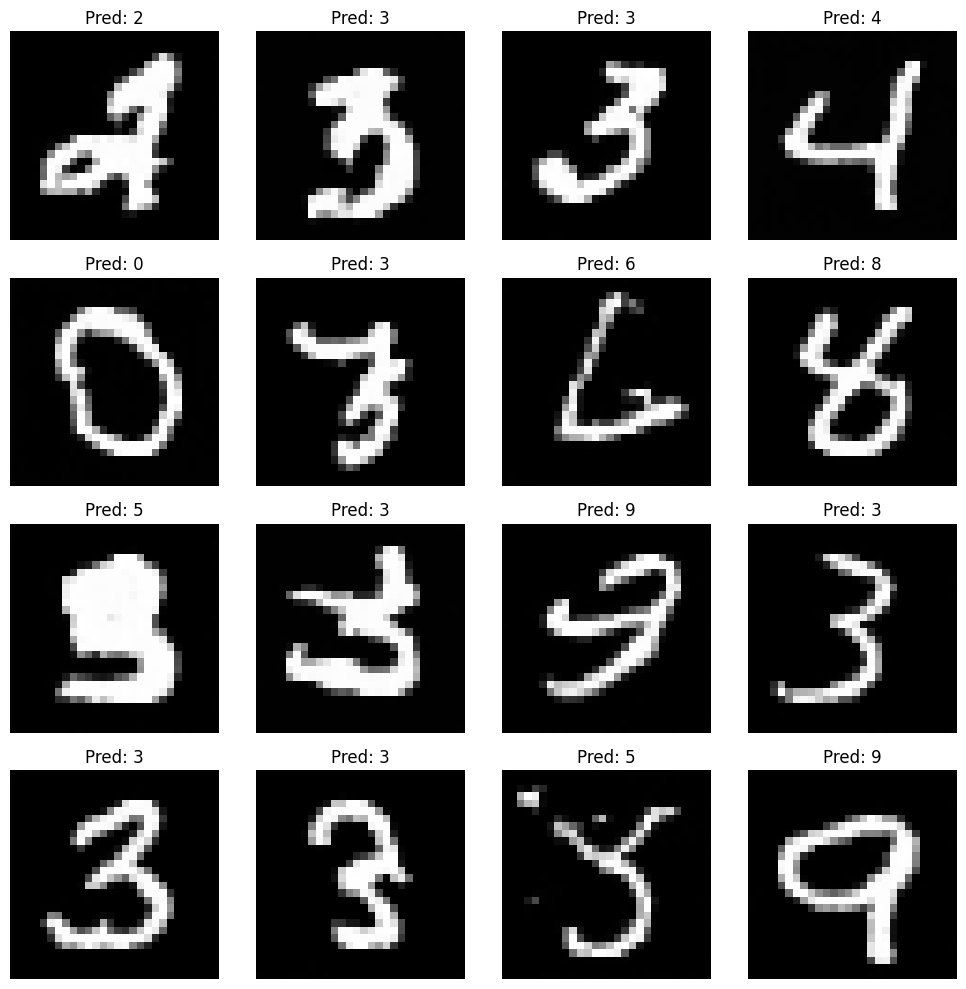

In [ ]:
# 3. Generate Digits with DDPM and Evaluate with Classifier
print("\n--- Generating and Evaluating DDPM Samples ---")
if not os.path.exists(DDPM_MODEL_PATH):
    print("DDPM model not trained or loaded. Cannot generate samples.")
elif not os.path.exists(CLASSIFIER_MODEL_PATH):
    print("Classifier model not trained or loaded. Cannot evaluate generated samples.")
else:
    unet_model.eval()
    mnist_classifier.eval()

    with torch.no_grad():
        num_generated_samples = 1024 # How many samples to generate for evaluation
        generated_image_steps = diffusion.sample(unet_model, IMG_SIZE, batch_size=num_generated_samples, channels=1)
        generated_images_final = generated_image_steps[-1].to(DEVICE) # Final images are on CPU, move to DEVICE

        # Generated images are in [-1, 1] range (same as DDPM training data)
        # Classifier was trained on MNIST data normalized with mean 0.1307, std 0.3081
        # We need to transform generated images to match classifier's expected input.
        # Current DDPM output: [-1, 1]
        # Step 1: Denormalize DDPM output to [0, 1]
        generated_images_0_1 = (generated_images_final + 1) / 2.0

        # Step 2: Normalize for classifier input (mean 0.1307, std 0.3081)
        classifier_normalize = transforms.Normalize((0.1307,), (0.3081,))
        generated_images_for_classifier = classifier_normalize(generated_images_0_1.clone()) # Use .clone() if modifying


        # Save a grid of generated images (denormalized to [0,1])
        grid = make_grid(generated_images_0_1.cpu(), nrow=8)
        save_image(grid, os.path.join(OUTPUT_DIR, "ddpm_final_generated_grid.png"))
        print(f"Saved final generated grid to {os.path.join(OUTPUT_DIR, 'ddpm_final_generated_grid.png')}")

        # Get classifier predictions (logits)
        classifier_outputs_logits = mnist_classifier(generated_images_for_classifier)

        # Get probabilities (softmax over logits)
        classifier_outputs_probs = F.softmax(classifier_outputs_logits, dim=1)

        # Get predicted classes (integers) and their probabilities
        predicted_probs, predicted_classes_int = torch.max(classifier_outputs_probs.data, 1)


        print(f"\nClassifier predictions for {num_generated_samples} DDPM-generated digits:")
        print(predicted_classes_int.cpu().numpy().reshape(-1, 8)) # Print in a grid-like format

        # Optional: Plot some generated images with their predicted classes
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            if i < num_generated_samples and i < 16: # Plot first 16
                img_to_plot = generated_images_0_1[i].cpu().squeeze().numpy() # Use [0,1] for plotting
                ax.imshow(img_to_plot, cmap='gray')
                ax.set_title(f"Pred: {predicted_classes_int[i].item()}")
                ax.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "ddpm_generated_with_predictions.png"))
        print(f"Saved plot of generated images with predictions to {os.path.join(OUTPUT_DIR, 'ddpm_generated_with_predictions.png')}")
        # plt.show()

        class_counts = torch.bincount(predicted_classes_int.cpu(), minlength=10)
        print("\nDistribution of predicted classes for generated samples:")
        for digit, count in enumerate(class_counts):
            print(f"Digit {digit}: {count.item()} samples")

        # --- FiftyOne Integration ---
        print("\n--- Creating FiftyOne Dataset ---")

        # Define a directory to store images for FiftyOne
        fiftyone_image_dir = os.path.join(OUTPUT_DIR, "fiftyone_generated_images")
        if os.path.exists(fiftyone_image_dir):
            shutil.rmtree(fiftyone_image_dir) # Clean up old images if re-running
        os.makedirs(fiftyone_image_dir, exist_ok=True)

        dataset_name = "ddpm_mnist_generated_samples"
        try:
            dataset = fo.load_dataset(dataset_name)
            dataset.delete() # Delete if exists to start fresh, or use dataset.clear()
            print(f"Deleted existing dataset: {dataset_name}")
        except ValueError:
            print(f"Dataset {dataset_name} not found, creating new one.")
            pass # Dataset doesn't exist, which is fine

        dataset = fo.Dataset(name=dataset_name, persistent=True) # persistent=True saves dataset meta to DB

        samples = []
        for i in range(num_generated_samples):
            img_tensor_0_1 = generated_images_0_1[i] # Already in [0,1] format

            # Save image to file
            img_filename = f"generated_img_{i:04d}.png"
            img_filepath = os.path.join(fiftyone_image_dir, img_filename)
            save_image(img_tensor_0_1.cpu(), img_filepath) # save_image expects CHW

            # Get classifier outputs for this specific sample
            sample_logits = classifier_outputs_logits[i].cpu().numpy().tolist()
            sample_probs = classifier_outputs_probs[i].cpu().numpy().tolist()
            sample_predicted_class_int = predicted_classes_int[i].item()
            sample_predicted_class_label = str(sample_predicted_class_int) # For FiftyOne classification
            sample_predicted_confidence = predicted_probs[i].item()

            # Create FiftyOne Sample
            sample = fo.Sample(filepath=img_filepath)

            # Add classification prediction
            sample["prediction"] = fo.Classification(
                label=sample_predicted_class_label,
                confidence=sample_predicted_confidence
            )

            # Add raw logits and probabilities as custom fields
            sample["probabilities"] = sample_probs # Store as fo.Vector
            sample["predicted_class_int"] = sample_predicted_class_int # Store integer class too

            samples.append(sample)

        dataset.add_samples(samples)
        print(f"Added {len(samples)} samples to FiftyOne dataset '{dataset_name}'.")
        print(f"Images for FiftyOne are stored in: {fiftyone_image_dir}")

        # You can now explore this dataset in the FiftyOne App
        # For example, in a Jupyter notebook:
        # session = fo.launch_app(dataset)
        # print("FiftyOne App launched. If in Colab, you might need to use session.show().")
        # If running in a script, you might want to print the command to launch it later:
        print(f"\nTo view the dataset in FiftyOne App, run:\nfiftyone app launch {dataset_name}")

        # Example of how to access the data later:
        # loaded_dataset = fo.load_dataset(dataset_name)
        # for sample in loaded_dataset.limit(5):
        #     print(f"Image: {sample.filepath}")
        #     print(f"  Predicted Label: {sample.prediction.label}")
        #     print(f"  Confidence: {sample.prediction.confidence}")
        #     print(f"  Probabilities (first 3): {sample.probabilities.values[:3]}")

print("\nDone.")

In [ ]:
session = fo.launch_app(dataset, auto=False)


Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.5.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.5.2

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



## In FiftyOne, try filtering the output by the confidence of the classifier

In [ ]:
print(session.url)

https://5151-gpu-t4-hm-2a99y9azf59j9-c.us-east1-0.prod.colab.dev?polling=true
